## 1 Preliminaries

## 1.1 Imports and Configurations

### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import math

from pathlib import Path
from pandas.api.types import CategoricalDtype
from ydata_profiling import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

### Constants

In [113]:
# 1 Preliminaries

RANDOM_STATE = 42

MARKETING_PATH =  Path('../data/raw/customer_shopping_data.csv')
REPORTS_DIR = Path('../reports/')

FEATURES_TO_DEL = ['invoice_no', 'customer_id']

FEATURE_OUTLIER_THRESHOLDS = {
    'price': {'upper': 4000},
}

FEATURES_CAT = ['gender', 'category', 'payment_method', 'shopping_mall']
FEATURES_DATE = ['invoice_date']

FEATURE_ORD_LEVELS = {
    'quantity': ['1', '2', '3', '4', '5'],
}

# 2 Feature Utility Scores

MI_SCORES_FEATURE_TO_ESTIMATE = 'category_quantity_mall_spent'
MI_SCORES_THRESHOLD = 0

## 3 Feature Engineering

FEATURES_NEW_TO_DEL = ['invoice_date', 'age']

FEATURE_NEW_ORD_LEVELS = {
    'quantity': ['1', '2', '3', '4', '5'],
    'age_group': ['Juvenile', 'Youth', 'Average', 'Elderly'],
}

PCA_N_COMPONENTS = 20
HOPKINS_B = 10

### Configs

In [114]:
warnings.filterwarnings('ignore')

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

REPORTS_DIR.mkdir(exist_ok=True)

## 1.2 Data Preprocessing

### Read

In [115]:
def read_data(path):
    return pd.read_csv(path)

In [116]:
df = read_data(MARKETING_PATH)
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


### Clean

In [117]:
def clean(df, features_to_del):
    df = df.drop(columns=features_to_del)
    df['category_quantity_mall_counts'] = df.groupby(['category', 'quantity', 'shopping_mall'])['price'].transform('count')
    df['category_quantity_mall_spent'] = df.groupby(['category', 'quantity', 'shopping_mall'])['price'].transform('sum')
    return df

In [118]:
df = clean(df, FEATURES_TO_DEL) 
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_quantity_mall_counts,category_quantity_mall_spent
0,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon,1380,2070552.00
1,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul,88,158444.88
2,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity,1040,312083.20
3,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM,228,684193.80
4,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon,168,10180.80


### Missing Values

In [119]:
df.isna().sum().sum()

0

### Outliers

In [120]:
def get_outlier_indexes(df, feature_outlier_thresholds):
    outlier_indexes = set()
    
    for feature, thresholds in feature_outlier_thresholds.items():
        if 'upper' in thresholds.keys():
            outlier_indexes = outlier_indexes.union(set(df[df[feature] > thresholds['upper']].index))
        elif 'lower' in thresholds.keys():
            outlier_indexes = outlier_indexes.union(set(df[df[feature] < thresholds['lower']].index))

    return list(outlier_indexes)

In [121]:
def drop_outliers(df, outlier_indexes):
    return df.drop(index=outlier_indexes)

In [122]:
outlier_indexes = get_outlier_indexes(df, FEATURE_OUTLIER_THRESHOLDS)
len(outlier_indexes)

2002

In [123]:
df_without_outliers = drop_outliers(df, outlier_indexes)
df_without_outliers.shape

(97455, 10)

### Encode

In [124]:
def encode(df, features_cat, features_date, feature_ord_levels, format='%d-%m-%Y'):
    
    def encode_cat(df, features_cat):
        for feature in features_cat:
            df[feature] = df[feature].astype('category')
        return df

    def encode_date(df, features_date):
        for feature in features_date:
            df[feature] = pd.to_datetime(df[feature], format=format)
        return df

    def encode_ord(df, feature_ord_levels):
        for feature, levels in feature_ord_levels.items():
            df[feature] = df[feature].astype('str').astype(CategoricalDtype(levels, ordered=True))
        return df
    
    df = encode_cat(df, features_cat)
    df = encode_date(df, features_date)
    df = encode_ord(df, feature_ord_levels)
    return df

In [125]:
df = encode(df, FEATURES_CAT,  FEATURES_DATE, FEATURE_ORD_LEVELS, format='%d/%m/%Y')
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_quantity_mall_counts,category_quantity_mall_spent
0,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,1380,2070552.00
1,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,88,158444.88
2,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,1040,312083.20
3,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,228,684193.80
4,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,168,10180.80


In [126]:
df.dtypes

gender                                 category
age                                       int64
category                               category
quantity                               category
price                                   float64
payment_method                         category
invoice_date                     datetime64[ns]
shopping_mall                          category
category_quantity_mall_counts             int64
category_quantity_mall_spent            float64
dtype: object

### Summary

In [127]:
def load_data(path, features_to_del, features_cat, features_date, feature_ord_levels):
    df = read_data(path)
    df = clean(df, features_to_del)
    #df = impute(df)

    outlier_indexes = get_outlier_indexes(df, FEATURE_OUTLIER_THRESHOLDS)
    df = drop_outliers(df, outlier_indexes)
    
    df = encode(df, features_cat, features_date, feature_ord_levels, format='%d/%m/%Y')
    return df

In [128]:
df = load_data(MARKETING_PATH, FEATURES_TO_DEL, FEATURES_CAT, FEATURES_DATE, FEATURE_ORD_LEVELS)
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_quantity_mall_counts,category_quantity_mall_spent
0,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,1380,2070552.00
1,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,88,158444.88
2,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,1040,312083.20
3,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,228,684193.80
4,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,168,10180.80


In [129]:
df.isna().sum().sum()

0

In [130]:
df.dtypes

gender                                 category
age                                       int64
category                               category
quantity                               category
price                                   float64
payment_method                         category
invoice_date                     datetime64[ns]
shopping_mall                          category
category_quantity_mall_counts             int64
category_quantity_mall_spent            float64
dtype: object

## 2 Feature Utility Scores

## 2.1 MI Scores

In [131]:
def make_mi_scores(X, y, random_state=0):
    X = X.copy()
    for feature in X.select_dtypes(['object', 'category', 'datetime64[ns]']):
        X[feature], _ = X[feature].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [132]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')

In [133]:
X_mi = df.copy()
y_mi = X_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

mi_scores = make_mi_scores(X_mi, y_mi, random_state=RANDOM_STATE)
mi_scores

category_quantity_mall_counts    5.197792
price                            3.408725
shopping_mall                    2.111768
category                         1.822894
quantity                         1.603832
gender                           0.003403
invoice_date                     0.000683
age                              0.000000
payment_method                   0.000000
Name: MI Scores, dtype: float64

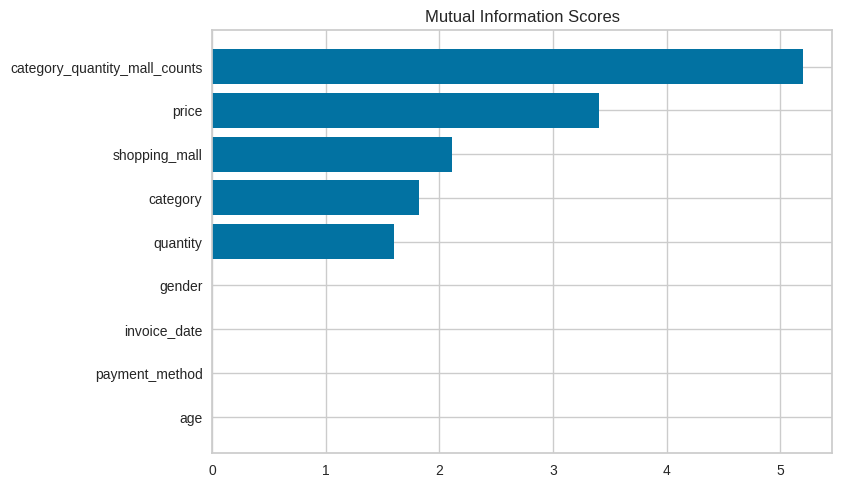

In [134]:
plot_mi_scores(mi_scores)

## 3 Feature Engineering

## 3.1 Create Features with Pandas

In [135]:
def extractions(df, feature_ord_levels):
    def split_by_age(age):
        if age <= 18:
            return 'Juvenile'
        if 19 <= age <= 44:
            return 'Youth'
        elif 45 <= age <= 59:
            return 'Average'
        elif 60 <= age:
            return 'Elderly'

    def get_season(invoice_date):
        season = invoice_date.dt.month % 12 // 3 + 1
        season = season.replace({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})
        return season

    X = pd.DataFrame()
    X['age_group'] = df.apply(lambda row: split_by_age(row['age']), axis=1) \
        .astype(CategoricalDtype(feature_ord_levels['age_group'], ordered=True))
    X['season'] = get_season(df['invoice_date']).astype('category')
    
    return X

In [136]:
def group_transforms(df):
    X = pd.DataFrame() 
    X['med_category_price'] = df.groupby('category')['price'].transform('median')
    X['med_quantity_price'] = df.groupby('quantity')['price'].transform('median')
    return X

## 3.2 Create Final Dataset

In [137]:
def create_features(df, feature_target, mi_threshold, feature_outlier_thresholds, 
                    feature_new_ord_levels, feature_new_to_del, random_state=0):
    X = df.copy()
    
    mi_scores = make_mi_scores(X.drop(columns=feature_target), X[feature_target], 
                               random_state=random_state)
    #X = drop_uninformative(X, feature_target, mi_scores, mi_threshold)

    outlier_indexes = get_outlier_indexes(X, feature_outlier_thresholds)
    X = drop_outliers(X, outlier_indexes)
    
    #X = X.join(math_transforms(X, last_year))
    #X = X.join(counts(X))
    X = X.join(extractions(X, feature_new_ord_levels))
    X = X.join(group_transforms(X))
    X = X.drop(columns=feature_new_to_del)
    
    return X

In [138]:
df_new = create_features(
    df, 
    MI_SCORES_FEATURE_TO_ESTIMATE,
    MI_SCORES_THRESHOLD,
    FEATURE_OUTLIER_THRESHOLDS,
    FEATURE_NEW_ORD_LEVELS,
    FEATURES_NEW_TO_DEL,
    random_state=RANDOM_STATE,
)

In [139]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97455 entries, 0 to 99456
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   gender                         97455 non-null  category
 1   category                       97455 non-null  category
 2   quantity                       97455 non-null  category
 3   price                          97455 non-null  float64 
 4   payment_method                 97455 non-null  category
 5   shopping_mall                  97455 non-null  category
 6   category_quantity_mall_counts  97455 non-null  int64   
 7   category_quantity_mall_spent   97455 non-null  float64 
 8   age_group                      97455 non-null  category
 9   season                         97455 non-null  category
 10  med_category_price             97455 non-null  float64 
 11  med_quantity_price             97455 non-null  float64 
dtypes: category(7), float64(4), int64(1)


## 3.3 MI Scores for New Features

In [140]:
X_new_mi = df_new.copy()
y_new_mi = X_new_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

new_mi_scores = make_mi_scores(X_new_mi, y_new_mi, random_state=RANDOM_STATE)
new_mi_scores

category_quantity_mall_counts    5.197824
price                            3.414103
shopping_mall                    2.111328
med_category_price               1.828466
category                         1.822925
quantity                         1.603863
med_quantity_price               1.603009
age_group                        0.002444
payment_method                   0.001756
gender                           0.000000
season                           0.000000
Name: MI Scores, dtype: float64

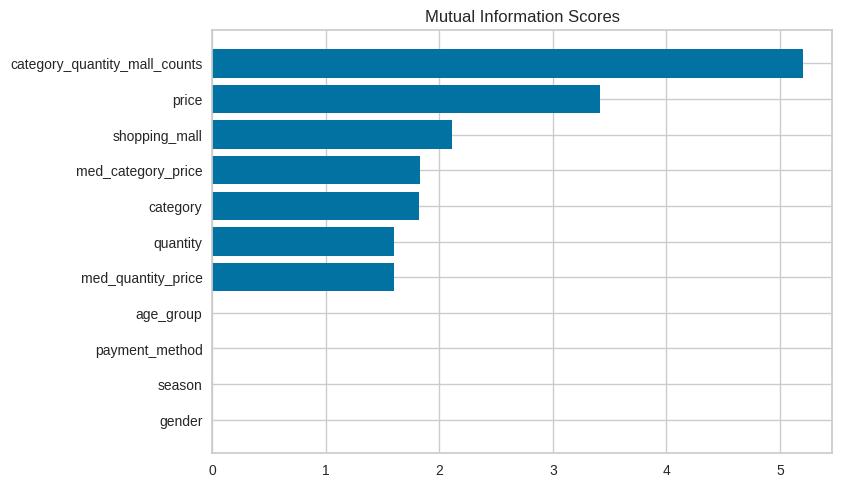

In [141]:
plot_mi_scores(new_mi_scores)

## 3.4 Feature Engineering Report

In [142]:
profiling_report = ProfileReport(df_new, title='Feature Engineering Profile Report')

In [143]:
profiling_report.to_file(REPORTS_DIR.joinpath('feature_engineering_report.html'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.5 Preprocessing Pipeline

In [144]:
def get_preprocessor(df, feature_ord_levels):
    features_num = list(df.select_dtypes(('int64', 'float64')).columns)
    features_ord = list(feature_ord_levels.keys())
    features_cat = [feature for feature in df.select_dtypes('category').columns \
                    if feature not in feature_ord_levels]

    assert len(features_num) + len(features_ord) + len(features_cat) == df.shape[1]
    
    num_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('transformer', QuantileTransformer()),
    ])

    cat_transformer = Pipeline([
        ('oh_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])
    
    ord_transformer = Pipeline([
        ('ord_encoder', OrdinalEncoder()),
    ])

    preprocessor = ColumnTransformer([
        ('num', num_transformer, features_num),
        ('ord', ord_transformer, features_ord),
        ('cat', cat_transformer, features_cat),
    ])
    return preprocessor

In [145]:
preprocessor = get_preprocessor(df_new, FEATURE_NEW_ORD_LEVELS)

In [146]:
X = pd.DataFrame(preprocessor.fit_transform(df_new))
X.columns = preprocessor.get_feature_names_out()

In [147]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97455 entries, 0 to 97454
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   num__price                            97455 non-null  float64
 1   num__category_quantity_mall_counts    97455 non-null  float64
 2   num__category_quantity_mall_spent     97455 non-null  float64
 3   num__med_category_price               97455 non-null  float64
 4   num__med_quantity_price               97455 non-null  float64
 5   ord__quantity                         97455 non-null  float64
 6   ord__age_group                        97455 non-null  float64
 7   cat__gender_Female                    97455 non-null  float64
 8   cat__gender_Male                      97455 non-null  float64
 9   cat__category_Books                   97455 non-null  float64
 10  cat__category_Clothing                97455 non-null  float64
 11  cat__category_C

## 3.6 Dimensionality Reduction

### PCA

In [148]:
def apply_pca(X, n_components=None, standardize=True, random_state=0):
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X)
    
    component_names = [f'PC{i + 1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=component_names,
        index=X.columns,
    )
    
    return pca, X_pca, loadings

In [149]:
def plot_variance(pca, width=8, dpi=100):
    fig, ax = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    evr = pca.explained_variance_ratio_
    ax[0].bar(grid, evr)
    ax[0].set(
        xlabel='Component',
        title='% Explained Variance',
        ylim=(0.0, 1.0),
    )
    
    cv = np.cumsum(evr)
    ax[1].plot(np.r_[0, grid], np.r_[0, cv], 'o-')
    ax[1].set(
        xlabel='Component',
        title='% Cumulative Variance',
        ylim=(0.0, 1.0),
    )
    
    fig.set(figwidth=width, dpi=dpi)
    plt.show()
    return ax

In [150]:
pca, _, _ = apply_pca(X, standardize=False, random_state=RANDOM_STATE)

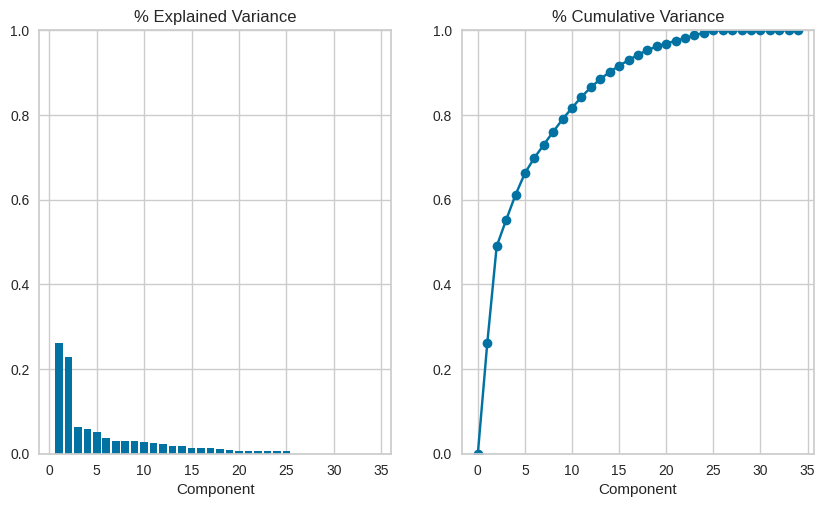

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

In [152]:
plot_variance(pca, width=10)